# LT Toolbox Tutorial

Welcome to the Lagrangian Trajectories Toolbox tutorial! 

The LT Toolbox is a python library dedicated to the post-processing, visualisation and analysis of Lagrangian water parcel trajectories. The toolbox makes use of [xarray](http://xarray.pydata.org/en/stable/#) multidimensional data arrays to store attribute variables associated with trajectories (e.g. lat, lon, in-situ temperature etc.).

In this tutorial, we will show how to:

+ **Store** the output of an example simulation of the [TRACMASS](https://tracmass.readthedocs.io/en/latest/) Lagrangian trajectory code in a trajectories object.

+ **Add** new variables, such as particle IDs and seeding levels, to your dataset.

+ **Filter** trajectories using any attribute variable contained in your dataset.

+ **Get** existing features, including trajectory start/end times, start/end locations and durations.

+ **Compute** metrics, such as distance travelled, particle displacements and the Lagrangian velocities from trajectories.

+ **Plot** trajectory data in the form of time series, temperature-salinity diagrams and more.

+ **Map** trajectories, properties and probability distributions onto the Earth's surface using [Cartopy](https://tracmass.readthedocs.io/en/latest/).

## Getting Started

Let us begin by importing the relevant packages we'll need to get started with the LT Toolbox. 

**Note**: Since lt_toolbox is still undergoing unit testing, the package is not yet available on PyPi, hence we use a local development version.

In [1]:
import xarray as xr
import numpy as np

# Navigating to the local development version of lt_toolbox.
%cd /Users/ollietooth/Desktop/D.Phil./lt_toolbox/

from lt_toolbox.trajectories import trajectories

/Users/ollietooth/Desktop/D.Phil./lt_toolbox


### Storing Trajectory Data

To explore the functionality of the LT Toolbox, we will use output from the example NEMO ORCA1 (3D) simulation contained in the TRACMASS [documentation](https://tracmass.readthedocs.io/en/latest/Examples.html). 

The simulation uses monthly mean velocity fields (24 months continuously looped over to generate a 200 year simulation) and releases particles southward from \~68 N for the first 24 months (seeding levels). Particles are terminated on reaching the equator or on re-encountering the seeding plane (\~ 68 N). The maximum lifetime for trajectories in the simulation is 200 years.

TRACMASS outputs trajectories in .csv files, so we first used the export_tracmass_to_nc.py file to reformat the output data into a .nc file conforming to the standard NCEI trajectory [template](https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/trajectoryIncomplete.cdl).

Below we load the resulting .nc file as a DataSet with xarray, before creating a trajectories object, traj.

In [2]:
# Navigate to the directory where the ORCA1 output data is stored.
%cd /Users/ollietooth/Desktop/D.Phil./lt_toolbox/lt_toolbox/

# Open output .nc file as a DataSet.
dataset = xr.open_dataset('ORCA1-N406_TRACMASS_complete.nc')

# Create a trajectories object from the DataSet.
traj = trajectories(dataset)

/Users/ollietooth/Desktop/D.Phil./lt_toolbox/lt_toolbox


**What is a trajectories object?**

The trajectories object, traj, hosts the original xarray DataSet accessible as an attribute with traj.data. 

For improved functionality, attribute variables (data variables stored in our DataSet) are made accessible with traj.{variable} to access a given {variable}.

The true value of a trajectories object comes with the use of the built-in functions specifically designed for post-processing, visualisation and analysis of Lagrangain water parcel trajectories.

### Exploring our trajectories object

By accessing the .data attribute of our trajectories object above, we can see that attribute variables are formatted with dimensions **traj** (trajectory) and **obs** (observation - represents one time-level).

**Note**: Since trajectories are of differing lengths, missing **obs** values for a given **traj** are filled as NaNs or NaTs (time).

In [3]:
# To return details of our original DataSet.
print(traj.data)

# To access the temp attribute variable.
print(traj.temp)

# Using datetime64 format for time instead of timedelta64.
# Start date of simulation is 2000-01-01
traj = traj.use_datetime('2000-01-01')

<xarray.Dataset>
Dimensions:     (obs: 120, traj: 20350)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) timedelta64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 ...
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
Attributes:
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    featureType:            trajectory
    title:                  ORCA1 Trial Sim
    summary:                Trial simulation of ORCA1 - seeding particles sou...
    TRACMASS_version:       v7 (2020-10-28)
    Conventions:            CF-1.6/CF-1.7
    date_created:           2020-12-29
    creator_name:           Ollie Tooth
    creator_email:          oliver_tooth@env-res.ox.ac.uk
    project:                ORCA1_Sim01
    creator_t

### Adding new attribute variables to our trajectories object.

To add a new attribute variable to a trajectories object, including appending it to the original DataSet, use the **.add_variable()** method. 

Two common attribute variables which a user may wish to add to their trajectories object, a unique trajectory id and the seeding level when a particles are released are included as seperate methods: **.add_id()** and **.add_seed()**.

In [4]:
# Suppose we would like to add the id and seeding level of all of our
# particles for future analysis. 

# We can combine methods on a single line to return both.
traj = traj.add_id().add_seed()

# Let's look at our new attribute variables.
print(traj.id)
print(traj.seed_level)

<xarray.DataArray 'id' (traj: 20350)>
array([    1,     2,     3, ..., 20348, 20349, 20350])
Dimensions without coordinates: traj
Attributes:
    long_name:      trajectory id
    standard_name:  id
    units:          none
<xarray.DataArray 'seed_level' (traj: 20350)>
array([ 1,  1,  1, ..., 24, 24, 24])
Dimensions without coordinates: traj
Attributes:
    long_name:      seeding level
    standard_name:  seed_level
    units:          none


In [ ]:
# Consider now if we wanted to create a new attribute variable, temp_K,
# to store the in-situ temperature in Kelvin. 

# Using .values to access the numpy array storing the values of temp.
temp_k = traj.temp.values + 273.15

# Dictionary of attributes of our new variable.
attrs = {'long_name': 'in-situ temperature in Kelvin',
         'standard_name': 'temp_K',
         'units': 'Kelvin'
        }

# Add temp_k as a new attribute variable to our trajectories object.
traj = traj.add_variable(temp_k, attrs)

# Let's see if temp_K has been added!
print(traj.temp_K)

### Filtering trajectories using an attribute variable.

Filtering our trajectories to include only those complete trajectories where a specific criteria is met is integral to Lagrangian analysis. 

The LT Toolbox includes two fully vectorised methods **.filter_between()** and **filter_equal()** to allow users to filter on any attribute variable conatined in their trajectories object.

In [ ]:
# Filtering all our trajectories to include only those released in 
# seeding level 1 and storing as a new trajectories object, traj_seed1.
traj_seed1 = traj.filter_equal('seed_level', 1, drop=False)

# Let's look at the data in traj_seed1 - only 864 particles were
# released in seeding level 1.
print(traj_seed1.data)

In [ ]:
# Filtering all our trajectories to include only those which travel 
# between 0 N - 25 N and storing as a new trajectories object, 
# traj_sublat.
traj_sublat = traj.filter_between('lat', 0, 25, drop=False)

# Let's look at the data in traj_sublat - only 560 particles were
# found between 0-25 N at any time during their trajectories.
print(traj_sublat.data)

### Filtering trajectories by time - A Special Case

It should be noted that when filter methods are called with a time attribute variable, rather than return complete trajectories, only the observations (**obs**) meeting the specified criteria are returned. 

In [ ]:
# Defining the min and maximum time levels to return obs for.
tmin = np.datetime64('2000-01-31')
tmax = np.datetime64('2000-03-31')

# Filtering between tmin and tmax, the values tmin and tmax are
# included, and storing as a new trajectories object, traj_subtime.
traj_subtime = traj.filter_between('time', tmin, tmax, drop=False)

# Let's look at the data in traj_subtime - only 4 (116) obs are 
# included as expected.
print(traj_subtime.data.time)

In [ ]:
# Defining the time level to return obs for.
tval = np.datetime64('2000-03-01')

# Filtering tval and storing as a new trajectories object,
# traj_subtime.
traj_subtime = traj.filter_equal('time', tval, drop=False)

# Let's look at the data in traj_subtime - only 1 (119) obs is 
# included as expected.
print(traj_subtime.data.time)

### Finding indices of trajectory points.

Often we would like to find the indices of the elements stored in a trajectories object meeting a specific condition. Here, we can use the __.find_between()__ and __.find_equal()__ methods. Both find methods return a tuple of arrays containing the indices for satisfactory trajectory points. 

In [ ]:
# Finding trajectory points where a particle is found between
# 0 N - 25 N and storing indices in ind_between.
ind_between = traj.find_between('lat', 0, 25)

# Let's look at the indices returned in ind_between.
print(ind_between)
# To access only the rows in ind_between.
print(ind_between[0])
# To access only the cols in ind_between.
print(ind_between[1])

In [ ]:
# Finding trajectory points where the in-situ temperature is -1.75C.
ind_equal = traj.find_equal('temp', -1.75)

# Let's look at the indices returned in ind_equal.
print(ind_equal)


### Filtering trajectories which intersect a polygon.

In [5]:
# Defining square as a list of (Lat, Lon) tuples storing the coordinates
# of the polygon boundary.
square = [(-60, 30), (-60, 35), (-30, 35), (-30, 30), (-60, 30)]

# Filtering all our trajectories to include only those which, at some 
# point in their life time intersect a simple polygon, square.
traj_poly = traj.filter_polygon(square, drop=False)

# Let's look at the resulting trajectories object- only 
traj_poly.data

<xarray.Dataset>
Dimensions:     (obs: 120, traj: 289)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 12.0 12.0 12.0 ... 1.986e+04 1.986e+04 nan
    time        (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT
    lat         (traj, obs) float64 67.39 67.02 66.6 66.15 ... 28.38 28.31 nan
    lon         (traj, obs) float64 -63.27 -63.07 -62.77 ... -40.08 -40.19 nan
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 ...
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 12 13 28 76 77 83 ... 19588 19602 19604 19686 19856
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 ... 24 24 24 24 24 24 24 24 24
Attributes:
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    featureType:            trajectory
    title:                  ORCA1 Trial Sim
    summary:                Trial simulation of ORCA1 - seeding particles sou...
    TRACMASS_version:       v7 (2020-10-28)
    Conventions:            CF-1.6/CF-1.7
    date_created:           2020-12-29
    creator_name:           Ollie Tooth
    creator_email:          oliver_tooth@env-res.ox.ac.uk
    project:                ORCA1_Sim01
    creator_type:           person
    creator_institution:    University of Oxford
    product_version:        1.0
    references:             TRACMASS - https://github.com/TRACMASS

In [ ]:
traj_poly.map_trajectories()

In [8]:
gyre = [(-49.18793315042404, 49.37148882530159),
 (-49.275469433082314, 49.43215205088787),
 (-50.00795586557467, 50.058576143094065),
 (-50.335438857887105, 50.695280702079835),
 (-49.98634752455879, 51.36018578972914),
 (-50.19395526407288, 51.98948919296186),
 (-50.631701011905854, 52.493813505944495),
 (-50.711419864117026, 52.593243461234195),
 (-51.16822140057796, 53.19146845089379),
 (-51.6922368561796, 53.77695617096755),
 (-51.983008239776524, 54.16813087692975),
 (-52.102457561228206, 54.36175109357048),
 (-52.489345618220156, 54.94019082958548),
 (-53.20004682994474, 55.48590341847862),
 (-53.34872258528833, 55.53860303461335),
 (-54.48789345392174, 55.8379475971598),
 (-54.98796533202402, 55.92980893454198),
 (-55.626519172130585, 56.11309398525799),
 (-56.31780457232678, 56.39397572889523),
 (-56.83936495649369, 56.92062432874726),
 (-57.094096296733284, 57.38902497596455),
 (-57.1321888637855, 57.462285954152314),
 (-57.43281968760989, 57.99712553730837),
 (-57.680056572261826, 58.53219225487974),
 (-57.59389767812843, 58.7260829837521),
 (-57.436889250581046, 59.11676685743855),
 (-57.22591274889733, 59.696148907093885),
 (-57.02825751152389, 59.96825178911662),
 (-56.70103537069889, 60.30988240912289),
 (-56.242905779796494, 60.67733080786191),
 (-55.678645544221496, 60.98043022142082),
 (-55.341776256386694, 61.14905386407092),
 (-54.3206097975048, 61.38712955620498),
 (-53.18727775311204, 61.254592720447214),
 (-53.10983287602104, 61.24062399721527),
 (-52.191437102078, 60.79402894233779),
 (-51.67794864685563, 60.54294281130052),
 (-51.290911075265704, 60.31406253107381),
 (-50.35241830926855, 60.02092716615897),
 (-49.88216690132292, 59.869154694101155),
 (-49.124194123357825, 59.71305076336961),
 (-47.93520999299349, 59.49856623028676),
 (-47.81473220840865, 59.46136145552445),
 (-46.696037896968605, 59.078860280415725),
 (-46.38872350853443, 58.98113662530336),
 (-45.492732595506226, 58.73616954386235),
 (-44.33998664687051, 58.56589518501265),
 (-43.379176313292184, 58.58570436240879),
 (-43.233914380709685, 58.585920602008066),
 (-43.196069162091895, 58.59696717959333),
 (-42.18025377128016, 58.85679969291908),
 (-41.58708455752802, 59.29153588776968),
 (-41.21024822126378, 59.56003190563298),
 (-40.848245742632294, 59.93140451202753),
 (-40.40468359364143, 60.55156615119484),
 (-40.32652243799484, 60.6958152154089),
 (-40.04188400081667, 61.16319076642644),
 (-39.44223936157312, 61.785338531536816),
 (-39.42887976152584, 61.80467680498693),
 (-38.79413924302179, 62.40548346278733),
 (-38.46932229830463, 62.703301412027315),
 (-37.3046115054549, 62.82923675944813),
 (-36.141561210793675, 62.996258797049826),
 (-35.880477622478956, 63.12954215728223),
 (-35.067944993757656, 63.65608405348971),
 (-34.903521885551164, 63.75265752491198),
 (-33.99132068700152, 64.36809402266877),
 (-33.98189302696528, 64.37289562611323),
 (-32.817658028215206, 64.80418882718081),
 (-31.557243082790663, 64.76001996469027),
 (-30.526959356108364, 64.47081458740207),
 (-30.616257513117873, 63.88565126507274),
 (-30.14740707299951, 63.347896455773075),
 (-30.118251564217434, 63.31022318521),
 (-29.289516203558748, 62.73380214774353),
 (-28.849715925529924, 62.14618554310911),
 (-29.028731974002085, 61.54477201852938),
 (-29.340817253436065, 60.93777855729818),
 (-29.53839493487044, 60.328677631290844),
 (-29.680366815866627, 59.716302201368954),
 (-29.734626756481703, 59.100762993626404),
 (-28.710089814832166, 58.49284122275449),
 (-28.678732713363488, 58.4867755217991),
 (-28.624052891527302, 58.49358462582592),
 (-27.555670532386884, 58.60507364478248),
 (-26.428866194546778, 58.89443988901282),
 (-25.731894053295463, 59.12552401560117),
 (-25.291721500988217, 59.23055769645329),
 (-24.149263389734465, 59.32691582230174),
 (-23.756639803596517, 59.11605317857499),
 (-24.04688351773074, 58.49671037062973),
 (-24.174421978687608, 58.37700094682521),
 (-24.828593989880183, 57.87486785564269),
 (-25.26665590551473, 57.24617779821686),
 (-25.316173967533217, 57.093485874659834),
 (-25.542603614920406, 56.610998787051486),
 (-25.418079098337667, 55.969878907463254),
 (-25.332211988386174, 55.81689974940193),
 (-25.11791803613761, 55.322344464098826),
 (-24.917299185793038, 54.6697530751274),
 (-24.777834011370143, 54.012110497982405),
 (-24.29435577406788, 53.421688289997256),
 (-24.21300396659137, 53.346096232009096),
 (-23.24357161136188, 52.81242503378361),
 (-22.751634855724358, 52.66328089601694),
 (-23.260192087829097, 52.22999547399475),
 (-24.286561697622634, 52.005031767605736),
 (-24.323682594970272, 52.003496820228555),
 (-25.380518120918513, 51.99221655487873),
 (-26.43695351980536, 51.94040787360937),
 (-27.49179157106095, 51.74234373983071),
 (-28.54179549268257, 51.392782680446096),
 (-28.764955835401096, 51.33252056228011),
 (-29.588525505897806, 51.154701474583376),
 (-30.63212529773817, 50.93547035637876),
 (-31.66986110880074, 50.627379407871786),
 (-31.674089037475223, 50.62631020115626),
 (-32.70606914864116, 50.382887388983065),
 (-33.74104046995109, 50.19525759230372),
 (-34.77661171192747, 50.083418416643504),
 (-35.810915534439594, 49.98231779645589),
 (-36.802450792791994, 49.85468500901584),
 (-36.84191301206452, 49.85084609089136),
 (-37.05665411958276, 49.84898399861653),
 (-37.878404403469666, 49.84471101993706),
 (-38.92335560278249, 49.977812883848316),
 (-39.97151868732625, 50.145423915480066),
 (-41.02283950037077, 50.34091801515501),
 (-41.35640187346218, 50.41280567210431),
 (-42.0805080012338, 50.58317307566706),
 (-43.13287542866825, 50.742863404725995),
 (-44.15935013842356, 50.62873074550883),
 (-44.78237949496997, 50.289240633766845),
 (-45.14139508464764, 50.08470381214242),
 (-45.921965928930184, 49.57373317125538),
 (-46.11678850006203, 49.49998208963915),
 (-47.114239328708294, 49.166936268388376),
 (-48.13031146568329, 49.0570941287976),
 (-49.187933150424044, 49.37148882530159)]


# Filtering all our trajectories to include only those which, at some 
# point in their life time intersect a gyre.
traj_gyre = traj.filter_polygon(gyre, drop=True)

# Let's look at the resulting trajectories object.
traj_gyre.data

<xarray.Dataset>
Dimensions:     (obs: 120, traj: 15499)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 3.0 3.0 3.0 3.0 ... 2.035e+04 2.035e+04 nan
    time        (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT
    lat         (traj, obs) float64 67.39 66.66 66.23 66.18 ... 63.48 63.15 nan
    lon         (traj, obs) float64 -63.27 -62.83 -63.25 ... 20.7 19.83 nan
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 ...
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 3 4 5 6 8 9 ... 20345 20346 20347 20348 20349 20350
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 ... 24 24 24 24 24 24 24 24 24
Attributes:
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    featureType:            trajectory
    title:                  ORCA1 Trial Sim
    summary:                Trial simulation of ORCA1 - seeding particles sou...
    TRACMASS_version:       v7 (2020-10-28)
    Conventions:            CF-1.6/CF-1.7
    date_created:           2020-12-29
    creator_name:           Ollie Tooth
    creator_email:          oliver_tooth@env-res.ox.ac.uk
    project:                ORCA1_Sim01
    creator_type:           person
    creator_institution:    University of Oxford
    product_version:        1.0
    references:             TRACMASS - https://github.com/TRACMASS

/Users/ollietooth/opt/anaconda3/envs/Tracmass/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


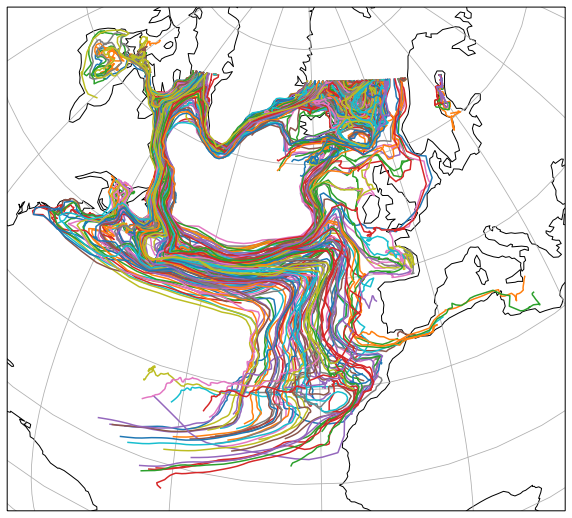

In [9]:
# Let's look at the resulting trajectories object- only 
traj_gyre.filter_equal('seed_level', 1).map_trajectories()

### Finding trajectory points that intersect a polygon.

In [7]:
# Finding trajectory points which intersect a simple polygon, square.
ind_poly = traj.find_polygon(square)

# Let's look at the resulting indices returned in ind_poly.
ind_poly

(array([   11,    11,    11, ..., 19685, 19685, 19855]),
 array([70, 71, 72, ..., 95, 96, 94]))

### Getting existing features from a trajectories object.

The LT Toolbox includes a range of .get_ methods to extract important features from existing attribute variables in a trajectories object. 

In [ ]:
# Get the times and locations when particle are released. 
traj = traj.get_start_time().get_start_loc()

# Get the times and locations when particles are terminated.
traj = traj.get_end_time().get_end_loc()


In [ ]:
# Get the maximum value of the temp variable for each trajectory. 
traj = traj.get_max('temp')

# Get the minimum value of the temp variable for each trajectory. 
traj = traj.get_min('temp')

# Get the value of the temp variable for each trajectory on 2000-01-01. 
traj = traj.get_value('temp', '2000-01-01')


In [ ]:
# Get the duration of each trajectory, t_total. 
traj = traj.get_duration()

# Let's look at the data in traj.
print(traj.data)

### Computing diagnostic metrics for trajectories.

Computation is a further important feature of the toolbox.

In particular, there are .compute methods available to compute the distance travelled by particles along their trajectories, particle displacements (zonal/meridional/vertical) and Lagrangian velocities (zonal/meridional/vertical).

Below we show how to combine **filter**, **compute** and **plot** methods to efficiently generate visualisations of output data.

In [ ]:
# Creating a time series plot of the meridional displacement travelled 
# by the first 10 particles in our ORCA1 output data.
traj.filter_between('id', 0, 9).compute_dy().plot_timeseries('dy')

In [ ]:
# Creating a time series plot of the meridional velocity travelled by 
# the first 10 particles in our ORCA1 output data.
traj.filter_between('id', 0, 9).compute_v().plot_timeseries('v')

### Further plotting of seawater properties.

Another useful plot for examining the water mass properties of a given trajectory is the temperature-salinity (t-s) diagram. 

We can very easily produce a t-s diagram with the LT Toolbox using the **.plot_ts_diagram** method.

In [ ]:
# Creating a t-s plot for the particles released between 2000-4000m
# in seeding level 1 and colouring by the particle longitude of 
# release.
traj.filter_equal('seed_level', 1).filter_between('z', -4000, -2000).plot_ts_diagram(col_variable='lon')

In [ ]:
# Plotting temperature of the particles released at the
# first seeding level on 2000-03-01 (3rd time level).
traj.plot_variable('temp', 'xz', 1, '2000-03-01')

### Mapping trajectories and probability distributions with Cartopy.

The LT Toolbox utilises the highly adaptable Cartopy geospatial visualisation package to map trajectories and their properties on the Earth's surface. 

Below we show how to use **.map_trajectories**, **.map_probability()** and **.map_property()** methods when anaysing trajectory output data.

In [ ]:
# Creating a map of trajectories released during the first seeding 
# levels (Jan - March).
traj.filter_equal('seed_level', 2).map_trajectories()

In [ ]:
# Creating a map of the trajectories of the first 20 particles released,
# coloured by the in-situ temperature.
traj.filter_between('id', 0, 10).map_trajectories(col_variable='temp')

In [ ]:
# Creating a map of the binned probability of particle pathways.
traj.map_probability(bin_res=1, prob_type='traj', cmap='viridis')

In [ ]:
# Creating a map of the binned probability of particle positions.
traj.map_probability(bin_res=1, prob_type='pos', cmap='viridis')

In [ ]:
# Creating a map of the binned mean temperature of particles.
traj.map_property(bin_res=1, variable='temp', statistic='mean')